In [1]:
from google.colab import drive
drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [2]:
#import libraries

import pandas as pd
import seaborn as sns
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Model
import matplotlib.pyplot as plt

In [3]:
#load the dataset, display

df = pd.read_json("/content/gdrive/MyDrive/Sarcasm Detection/Sarcasm_Headlines_Dataset.json", lines = True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


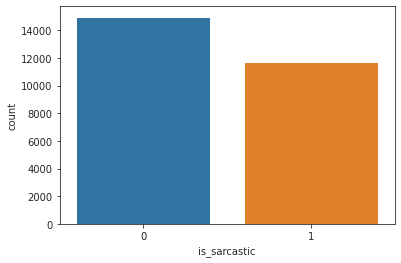

In [5]:
# Plot class distribution with labels

sns.set_style("ticks")
sns.countplot(df.is_sarcastic)

#about 14000 not, 12000 sarc

In [6]:
#making sure there is a class balance (if not, will need to augment data)

print(df.is_sarcastic.value_counts())
len(df)

0    14985
1    11724
Name: is_sarcastic, dtype: int64


26709

In [7]:
#define X (features) and y (output)
#all rows, 1st column
X = df.iloc[:,1]
#all rows, 2nd column
Y = df.iloc[:,2]

In [8]:
#split into train and test using lib
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size= 0.2)
len(X_train)

21367

In [9]:
# Data preprocessing

max_words = 1000
#max 150 words per sentence (< will be filled with 0, > will be truncated)
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
sequences_matrix.shape

(21367, 150)

In [10]:
#RNN shape/archictecture

def RNN():

  #put x as input
  inputs = Input(name='inputs', shape=[max_len])
  #for each word, get a vector of numbers (len = max)
  layer = Embedding(max_words, 50, input_length=max_len)(inputs)
  layer = LSTM(64)(layer)
  #256 neurons
  layer = Dense(256, name='FC1')(layer)
  #activation for Dense
  layer = Activation('relu')(layer)
  layer = Dropout(0.2)(layer)
  layer = Dense(1, name='out_layer')(layer)
  layer = Activation('sigmoid')(layer)
  model = Model(inputs=inputs, outputs=layer)
  return model

In [11]:
#compile the model

model = RNN()
model.summary()
#define loss func, optimzer, and metric
model.compile(loss = 'binary_crossentropy', optimizer = RMSprop(), metrics=['accuracy'])


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           50000     
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257   

In [12]:
#fit the model

#create the validation set, train model
history = model.fit(sequences_matrix, Y_train, batch_size=100, epochs=5, validation_split = 0.1)


Epoch 1/5
193/193 [==============================] - 34s 44ms/step - loss: 0.8820 - accuracy: 0.6215 - val_loss: 0.4295 - val_accuracy: 0.7983
Epoch 2/5
193/193 [==============================] - 7s 37ms/step - loss: 0.4003 - accuracy: 0.8172 - val_loss: 0.3952 - val_accuracy: 0.8128
Epoch 3/5
193/193 [==============================] - 7s 38ms/step - loss: 0.3699 - accuracy: 0.8374 - val_loss: 0.3995 - val_accuracy: 0.8166
Epoch 4/5
193/193 [==============================] - 7s 37ms/step - loss: 0.3567 - accuracy: 0.8406 - val_loss: 0.3893 - val_accuracy: 0.8184
Epoch 5/5
193/193 [==============================] - 7s 37ms/step - loss: 0.3397 - accuracy: 0.8481 - val_loss: 0.3865 - val_accuracy: 0.8264


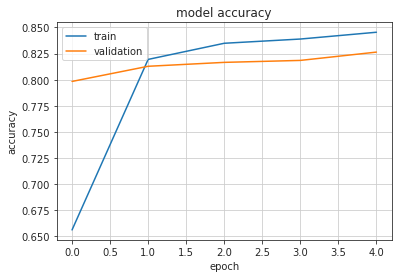

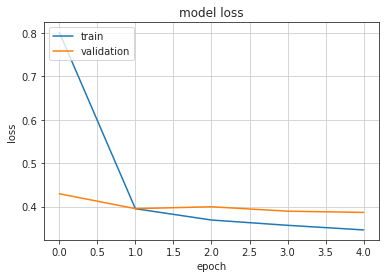

In [13]:
#plot training and val accuracy/loss
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
#Evaluate on the test set

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)
test_sequences_matrix.shape

(5342, 150)

In [15]:
accr = model.evaluate(test_sequences_matrix, Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0], accr[1]))

#end accuracy = 82.4%, loss = 0.380

167/167 [==============================] - 2s 13ms/step - loss: 0.3796 - accuracy: 0.8240
Test set
  Loss: 0.380
  Accuracy: 0.824
